In [1]:
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import copy, time
import random
import pickle
import scipy

import mlrfit as mf
from tqdm import tqdm

import hfmfit as hf

/Users/parshakova.tanya/opt/anaconda3/envs/routing/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
np.random.seed(1001)
random.seed(1001)

In [3]:
M = 5
m = 300
N = 50
rank = 40

# for _ in tqdm(range(M)):
for _ in range(M):
    # num_levels = int(np.ceil(np.log2(min(m, m))) + 1)
    hpart = mf.random_hpartition(m,  m, level_list=None, symm=True)
    ranks = mf.uniform_capped_ranks(rank, hpart)
    hat_A = mf.MLRMatrix(hpart=hpart, ranks=ranks, debug=True)
    hat_A.construct_sparse_format()
    hat_A.B[:, -1] = np.abs(hat_A.B[:, -1]) + 1e-3
    hat_A.C = hat_A.B
    # hat_A.C[:, -1] = np.abs(hat_A.C[:, -1]) + 1e-3

    part_sizes = []
    for level in range(len(hat_A.hpart['rows']['lk'])):
        part_sizes += [hat_A.hpart['rows']['lk'][level].size-1]

    F0, D0 = hat_A.B[:, :-1], np.square(hat_A.B[:, -1:])
    assert F0.shape[1] == rank-1 and np.allclose(np.concatenate([F0, np.sqrt(D0)], axis=1), hat_A.B)
    D0 = D0[:, 0]
    F_hpart = {"lk": hat_A.hpart['rows']['lk'][:-1], "pi":hat_A.hpart['rows']['pi']}

    tilde_F0 = mf.convert_compressed_to_sparse(F0, F_hpart, ranks[:-1])
    Sigma0 = hf.perm_hat_Sigma(F0, D0, F_hpart, ranks) 
    assert np.allclose(Sigma0, tilde_F0 @ tilde_F0.T + np.diag(D0.flatten()))
    assert np.allclose(Sigma0[hat_A.pi_inv_rows, :][:, hat_A.pi_inv_cols], hat_A.matrix())

    row_selectors, si_groups, F_hpart = hf.row_col_selections(hat_A.hpart)
    num_sparsities = row_selectors.size - 1
    lu, piv = scipy.linalg.lu_factor(Sigma0)
    Y = np.random.randn(N, m)
    for si in tqdm(range(num_sparsities)):
        r1, r2 = row_selectors[si: si+2]
        si_col = hf.group_to_indices(si_groups[si], part_sizes, ranks)
        ri_F0_ciT = F0[r1:r2, :]
        # test column selection in group_to_indices
        assert np.allclose(ri_F0_ciT, tilde_F0[r1:r2, si_col].todense())
        ri_At_ci_t, ci_B_ci, r1, r2 = hf.EM_intermediate_matrices(tilde_F0, Y, lu, piv, ranks, si, part_sizes, si_groups, row_selectors)

        # computation of diagonal D
        M1 = (1/N) * np.diag(Y[:, r1:r2].T @ Y[:, r1:r2] - 2 * ri_F0_ciT @ ri_At_ci_t + ri_F0_ciT @ ci_B_ci @ ri_F0_ciT.T)
        M2 = (1/N) * ( np.einsum('ij,ji->i', Y[:, r1:r2].T, Y[:, r1:r2]) \
                            - 2 * np.einsum('ij,ji->i', ri_F0_ciT, ri_At_ci_t) \
                            + np.einsum('ij,jk,ki->i', ri_F0_ciT, ci_B_ci, ri_F0_ciT.T))
        assert np.allclose(M1, M2)
        assert np.allclose(np.sum(M1 * np.power(D0[r1:r2], -1)), 
                           np.trace(np.diag(M1) @ np.diag(np.power(D0[r1:r2], -1))))

num_levels=10, num_sparsities=256
(256, 9) [  0   1   3   7  15  31  63 127 255]


100%|██████████| 256/256 [00:00<00:00, 1048.66it/s]


num_levels=10, num_sparsities=256
(256, 9) [  0   1   3   7  15  31  63 127 255]


100%|██████████| 256/256 [00:00<00:00, 1135.98it/s]


num_levels=10, num_sparsities=256
(256, 9) [  0   1   3   7  15  31  63 127 255]


100%|██████████| 256/256 [00:00<00:00, 1161.74it/s]


num_levels=10, num_sparsities=256
(256, 9) [  0   1   3   7  15  31  63 127 255]


100%|██████████| 256/256 [00:00<00:00, 1151.35it/s]


num_levels=10, num_sparsities=256
(256, 9) [  0   1   3   7  15  31  63 127 255]


100%|██████████| 256/256 [00:00<00:00, 1024.02it/s]


In [4]:
M = 100
m = 300
N = 50
rank = 40

# for _ in tqdm(range(M)):
for _ in range(M):
    # num_levels = int(np.ceil(np.log2(min(m, m))) + 1)
    hpart = mf.random_hpartition(m,  m, level_list=None, symm=True)
    ranks = mf.uniform_capped_ranks(rank, hpart)
    hat_A = mf.MLRMatrix(hpart=hpart, ranks=ranks, debug=True)

    F0, D0 = np.random.randn(m, rank-1), np.square(np.random.rand(m)) + 1

    row_selectors, si_groups, F_hpart = hf.row_col_selections(hat_A.hpart)
    loglikelihoods = [-np.inf]
    for t in range(20):
        Sigma0 = hf.perm_hat_Sigma(F0, D0, F_hpart, ranks)
        lu, piv = scipy.linalg.lu_factor(Sigma0)
        loglikelihoods += [hf.loglikelihood_value(Sigma0, lu, piv, Y)]
        if t > 0:
            q_00 = hf.q_thetap_theta_value(F0, D0, F0, lu, piv, Y, row_selectors, si_groups, ranks, part_sizes, F_hpart)
            q_10 = hf.q_thetap_theta_value(F1, D1, F0, lu, piv, Y, row_selectors, si_groups, ranks, part_sizes, F_hpart)
            assert q_10 + 1e-4 >= q_00, print(q_10, q_00)
        # print(f"{t=}, {loglikelihoods[-1]}")
        F1 = hf.EM_get_F(F0, lu, piv, Y, ranks, part_sizes, F_hpart, row_selectors, si_groups)
        D1 = hf.EM_get_D(F0, F1, lu, piv, Y, ranks, part_sizes, F_hpart, row_selectors, si_groups)
        F0, D0 = F1, D1
        assert D1.min() >= -1e-8 and loglikelihoods[-2] - 1e-8 <= loglikelihoods[-1], print(loglikelihoods[-5:])
    print(f"{loglikelihoods[1]=}, {loglikelihoods[-1]=}")

num_levels=10, num_sparsities=256
(256, 9) [  0   1   3   7  15  31  63 127 255]
loglikelihoods[1]=-753.6372539527067, loglikelihoods[-1]=-282.20986713667537
num_levels=10, num_sparsities=256
(256, 9) [  0   1   3   7  15  31  63 127 255]
loglikelihoods[1]=-752.7646024883942, loglikelihoods[-1]=-282.1563629965833
num_levels=10, num_sparsities=256
(256, 9) [  0   1   3   7  15  31  63 127 255]
loglikelihoods[1]=-751.400231782786, loglikelihoods[-1]=-282.212993628843
num_levels=10, num_sparsities=256
(256, 9) [  0   1   3   7  15  31  63 127 255]
loglikelihoods[1]=-755.4589770856064, loglikelihoods[-1]=-283.76682463295174
num_levels=10, num_sparsities=256
(256, 9) [  0   1   3   7  15  31  63 127 255]
loglikelihoods[1]=-754.0996929944714, loglikelihoods[-1]=-279.8664037410366
num_levels=10, num_sparsities=256
(256, 9) [  0   1   3   7  15  31  63 127 255]
loglikelihoods[1]=-753.3954847697074, loglikelihoods[-1]=-283.00241186930197
num_levels=10, num_sparsities=256
(256, 9) [  0   1   3  

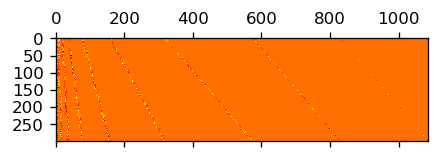

In [5]:
fig, ax = plt.subplots(figsize=(4, 8), dpi=120)
cax = ax.matshow(tilde_F0.toarray(), cmap='hot')
# fig.colorbar(cax)
plt.show()

F0.shape, len(F_hpart["lk"])

In [6]:
-(11946.49498228716 - 12110.802108897806) / 11946.49498228716 * 100

1.375358436547794

In [7]:
(12110.802108897806 - 11808.569944996309) / 11808.569944996309 * 100

2.559430695751294